In [1]:
import mlflow
import os
import pandas as pd
import sys

sys.path.append('../')

# Data Collection

- Scrape 20 years of data from pro football reference

In [ ]:
from src.scraper import ProFootballReferenceScraper

scraper = ProFootballReferenceScraper(data_dir="../data")
scraper.scrape_years(start_year=1999, end_year=2024)

# Data Processing

- Combine the stat tables for all years and save them to the silver layer
- Build the gold table from the different stat tables

In [ ]:
from src.processor import DataProcessor

processor = DataProcessor(data_dir="../data")
processor.process_all_data()

## Data Analysis 

- Do some data quality checks on the final stats
- Look at which features are the most and least informative

In [ ]:
from src.analysis import DataAnalysis

analysis = DataAnalysis()

In [ ]:
analysis.run_training_data_quality_checks()
analysis.run_live_data_quality_checks()

In [ ]:

analysis.generate_feature_analysis()

## Modelling

- Start with linear regression
- Become more advanced
- Forward, Backward, Feature Selection
- Models per target

In [ ]:
from src.modelling import FantasyModel

# model = FantasyModel(data_dir="../data", target_col="ppr_fantasy_points_per_game")
# model = FantasyModel(data_dir="../data", target_col="ppr_fantasy_points")
# model = FantasyModel(data_dir="../data", target_col="standard_fantasy_points_per_game")
# model = FantasyModel(data_dir="../data", target_col="standard_fantasy_points")
model = FantasyModel(data_dir="../data", target_col="value_over_replacement")

In [ ]:

data = model.split_data()

In [ ]:
model_eval_search = model.run_model_eval(data)

model_eval_results_df = pd.DataFrame(model_eval_search.cv_results_)

display(model_eval_results_df[['param_model', 'mean_test_r2', 'mean_test_rmse', 'std_test_r2']].sort_values(by='mean_test_r2', ascending=False))

In [ ]:
ridge_eval_search = model.run_model_tuning(data, "ridge")

ridge_eval_results_df = pd.DataFrame(ridge_eval_search.cv_results_)

display(
    ridge_eval_results_df[['param_model__alpha', 'mean_test_r2', 'mean_test_rmse', 'std_test_r2']]
    .sort_values(by=['mean_test_r2', 'mean_test_rmse'], ascending=[False, True])
)

In [ ]:
random_forest_eval_search = model.run_model_tuning(data, "random_forest")

random_forest_eval_results_df = pd.DataFrame(random_forest_eval_search.cv_results_)

display(
    random_forest_eval_results_df[['param_model__n_estimators', 'param_model__max_depth', 'mean_test_r2', 'mean_test_rmse', 'std_test_r2']]
    .sort_values(by=['mean_test_r2', 'mean_test_rmse'], ascending=[False, True])
)

In [ ]:
gradient_boosting_eval_search = model.run_model_tuning(data, "hist_gradient_boosting")

gradient_boosting_eval_results_df = pd.DataFrame(gradient_boosting_eval_search.cv_results_)

display(
    gradient_boosting_eval_results_df[['param_model__learning_rate', 'param_model__max_depth', 'param_model__min_samples_split', 'param_model__min_samples_leaf', 'mean_test_r2', 'mean_test_rmse', 'std_test_r2']]
    .sort_values(by=['mean_test_r2', 'mean_test_rmse'], ascending=[False, True])
)

In [ ]:
lasso_eval_search = model.run_model_tuning(data, "lasso")

lasso_eval_results_df = pd.DataFrame(lasso_eval_search.cv_results_)

display(
    lasso_eval_results_df[['param_model__alpha', 'mean_test_r2', 'mean_test_rmse', 'std_test_r2']]
    .sort_values(by=['mean_test_r2', 'mean_test_rmse'], ascending=[False, True])
)

## Final Predictions!

#### First on the test set

In [ ]:
test_preds_df = model.make_test_predictions(data, "lasso")

view_year = 2024
year_test_preds = model.view_year_test_predictions(test_preds_df, view_year)

print(f"Predictions for {model.target_col} in {view_year}:")
print(year_test_preds.head(10))

#### Now for 2025

In [ ]:
live_preds_df = model.make_live_predictions(data, "lasso")

print(f"Live predictions for {model.target_col}:")
print(live_preds_df.head(10))

## Rankings!

2025-08-10 13:58:28,863 - src.rankings - INFO - qb rankings saved to ../data/rankings/2025/ppr_fantasy_points_per_game/qb.csv
2025-08-10 13:58:28,864 - src.rankings - INFO - rb rankings saved to ../data/rankings/2025/ppr_fantasy_points_per_game/rb.csv
2025-08-10 13:58:28,865 - src.rankings - INFO - wr rankings saved to ../data/rankings/2025/ppr_fantasy_points_per_game/wr.csv
2025-08-10 13:58:28,866 - src.rankings - INFO - te rankings saved to ../data/rankings/2025/ppr_fantasy_points_per_game/te.csv
2025-08-10 13:58:28,868 - src.rankings - INFO - overall rankings saved to ../data/rankings/2025/ppr_fantasy_points_per_game/overall.csv


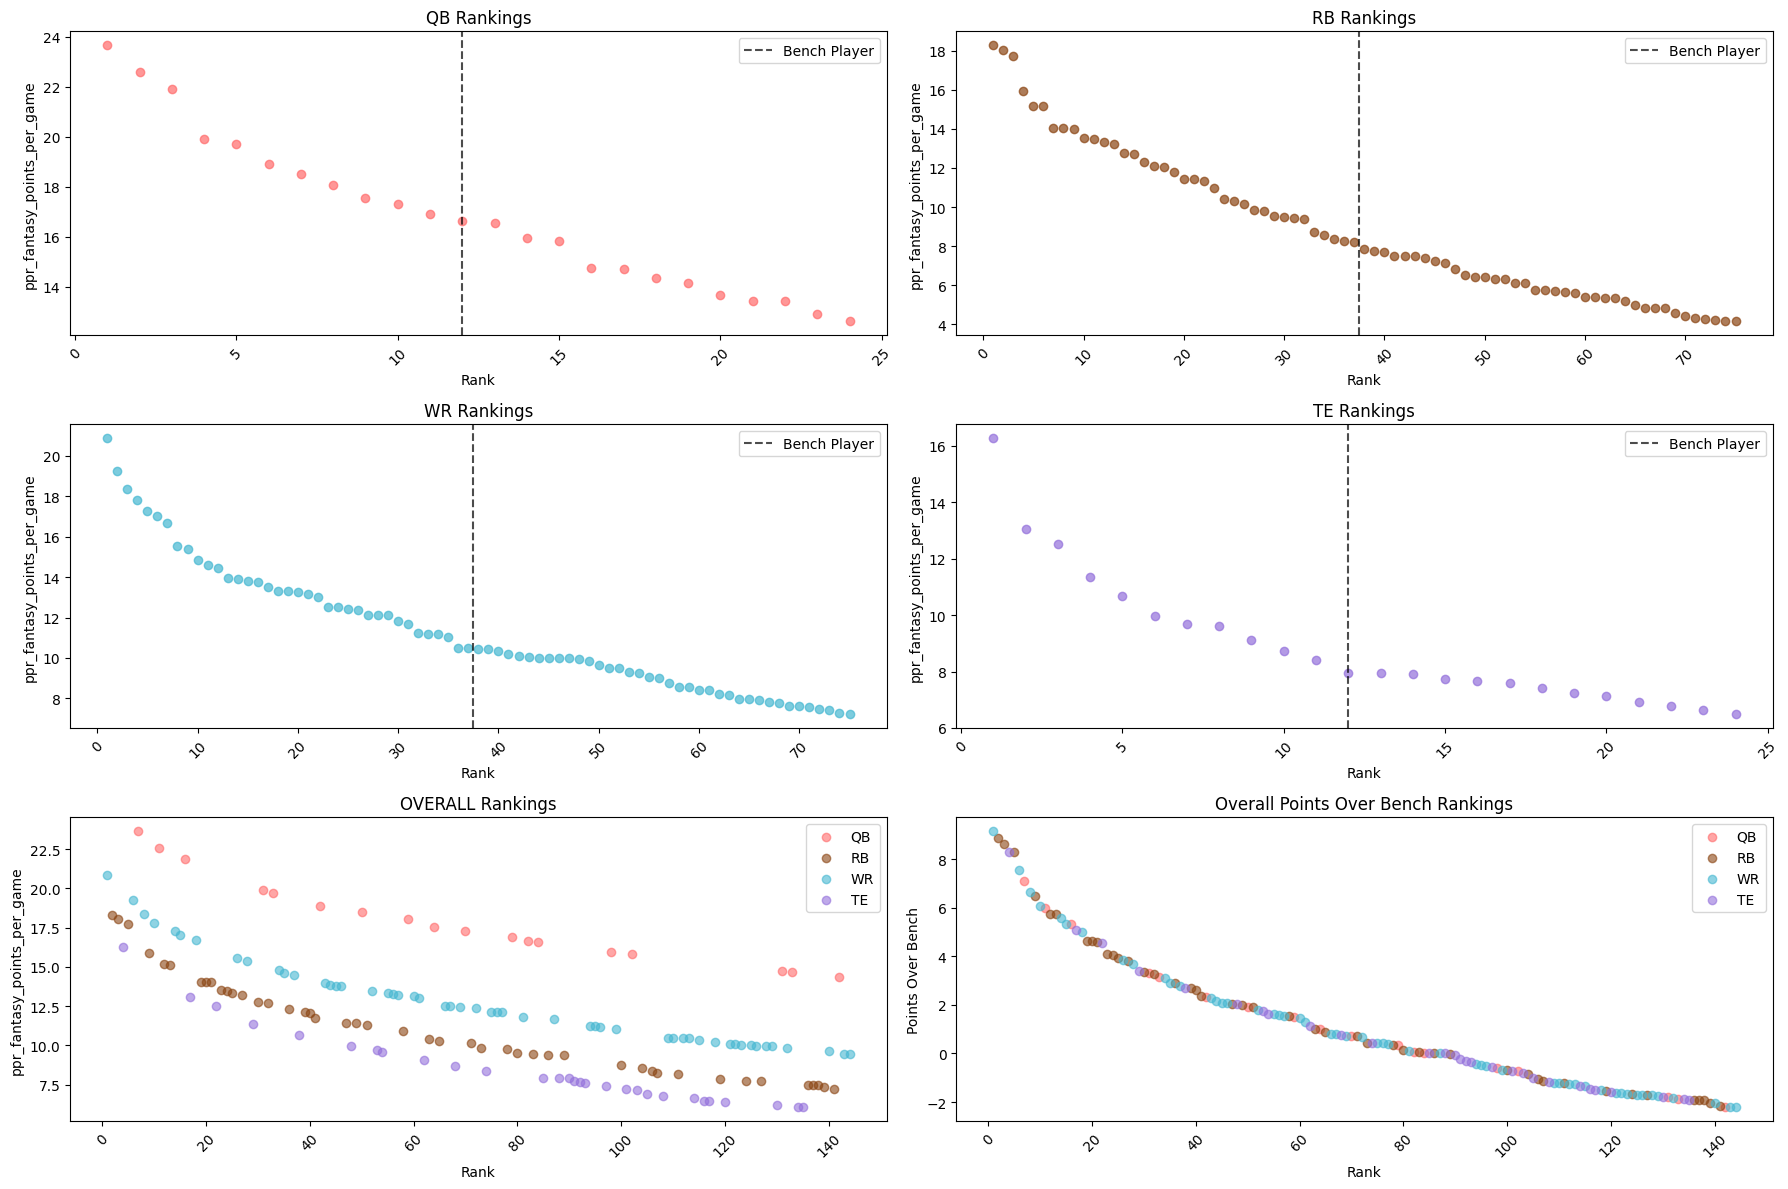

In [2]:
from src.rankings import Rankings

ranker = Rankings(year=2025, target_col="ppr_fantasy_points_per_game")
rankings = ranker.build_rankings()

ranker.plot_rankings(rankings)